<a href="https://colab.research.google.com/github/emmanuelkyeremeh/crop-disease-detection/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=10

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/Colab Notebooks/Crop_Disease_Detection/Crop_disease_detection_dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 21313 files belonging to 12 classes.


In [ ]:

class_names = ['Bacterial spot of bell Pepper',
 'Healthy Bell Pepper',
 'Bacterial spot of Tomato',
 'Early blight of Tomato',
 'Late blight of Tomato',
 'Leaf mold of Tomato',
 'Septoria leaf spot of Tomato',
 'Spider mites or Two-spotted spider mite of Tomato',
 'Target Spot of Tomato',
 'Yellow leaf curl virus of Tomato',
 'Mosaic virus of Tomato',
 'Healthy Tomato']
class_names

['Bacterial spot of bell Pepper',
 'Healthy Bell Pepper',
 'Bacterial spot of Tomato',
 'Early blight of Tomato',
 'Late blight of Tomato',
 'Leaf mold of Tomato',
 'Septoria leaf spot of Tomato',
 'Spider mites or Two-spotted spider mite of Tomato',
 'Target Spot of Tomato',
 'Yellow leaf curl virus of Tomato',
 'Mosaic virus of Tomato',
 'Healthy Tomato']

In [ ]:
dataset.class_names

['Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
dataset = dataset.shuffle(50, reshuffle_each_iteration=False)

In [ ]:
for image_batch, labels_batch in dataset.take(1): #take one batch of images and print its shape or convert to numpy
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[ 5  7  8  2  7 11  2  9  1 10  9  2  9  2  6  8  9  9  4  2  9  9  9 11
  9  9  6  2  4  4  4  3]


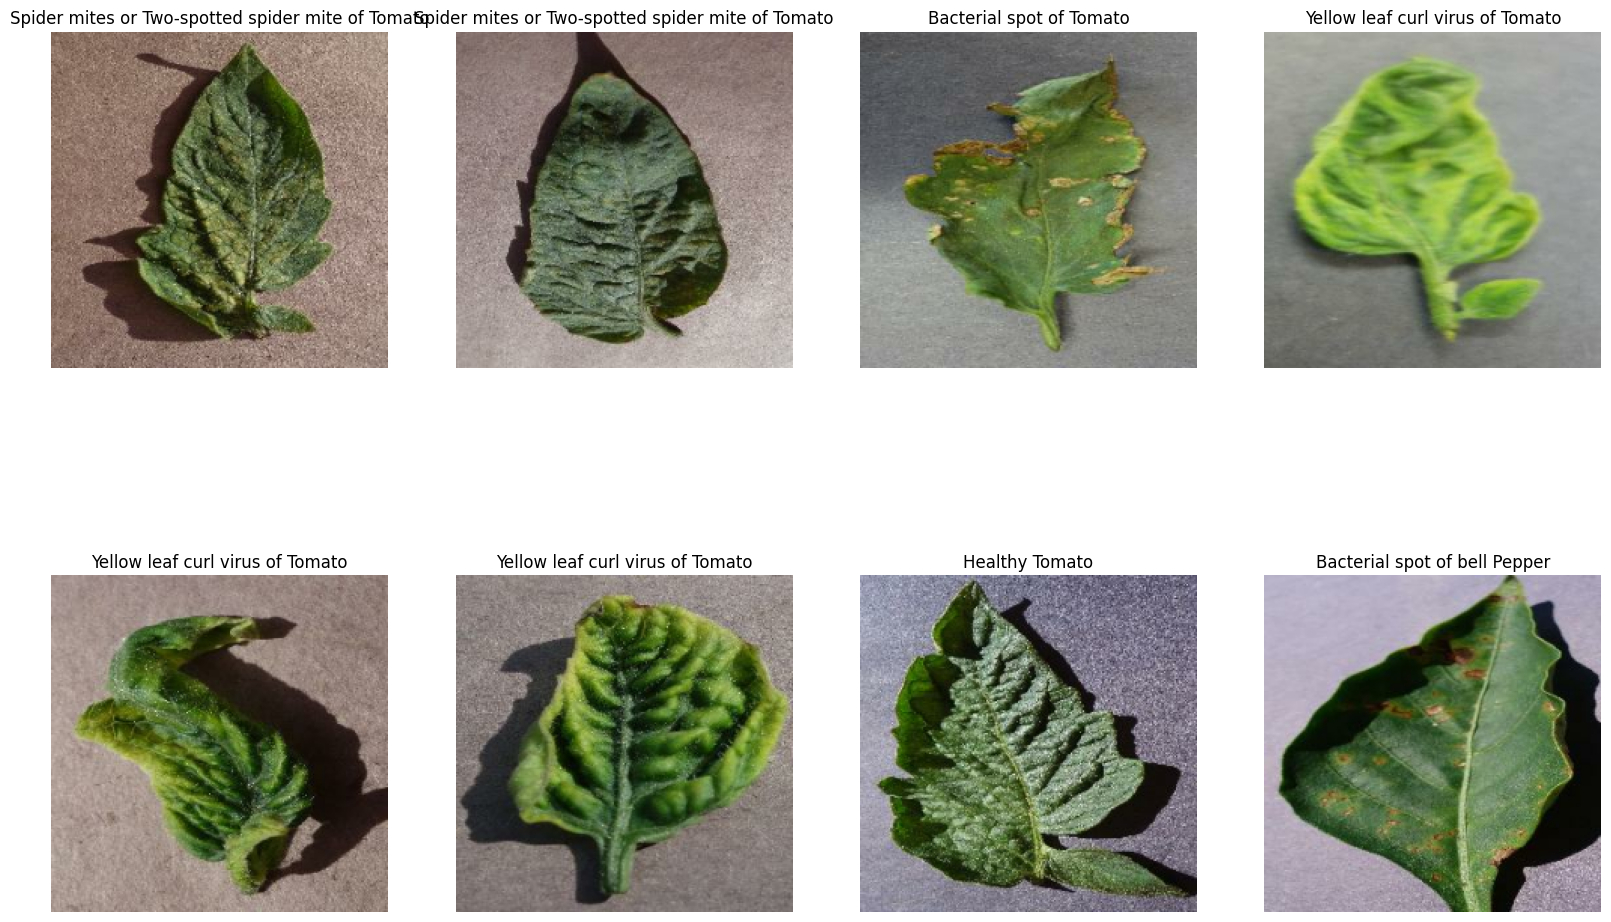

In [ ]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

667

In [ ]:
#data split
#80% training
#20% (10% Validation, 10% testing)

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False, shuffle_size=100):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print(len(train_ds) +len(val_ds) +len(test_ds))

667


In [ ]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train_ds = train_ds.cache().shuffle(300).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(300).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(300).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=input_shape, trainable=False)

In [ ]:
n_classes = 12

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 keras_layer (KerasLayer)    (32, 1280)                2257984   
                                                                 
 dense (Dense)               (32, 12)                  15372     
                                                                 
Total params: 2,273,356
Trainable params: 15,372
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


533/533 [==============================] - 2220s 4s/step - loss: 0.7047 - accuracy: 0.7853 - val_loss: 0.4396 - val_accuracy: 0.8722
Epoch 2/10
533/533 [==============================] - 831s 2s/step - loss: 0.3856 - accuracy: 0.8782 - val_loss: 0.3700 - val_accuracy: 0.8887
Epoch 3/10
533/533 [==============================] - 840s 2s/step - loss: 0.3260 - accuracy: 0.8957 - val_loss: 0.3312 - val_accuracy: 0.8906
Epoch 4/10
533/533 [==============================] - 842s 2s/step - loss: 0.2976 - accuracy: 0.9048 - val_loss: 0.3182 - val_accuracy: 0.8930
Epoch 5/10
533/533 [==============================] - 852s 2s/step - loss: 0.2727 - accuracy: 0.9118 - val_loss: 0.3269 - val_accuracy: 0.8892
Epoch 6/10
533/533 [==============================] - 840s 2s/step - loss: 0.2642 - accuracy: 0.9121 - val_loss: 0.2720 - val_accuracy: 0.9081
Epoch 7/10
533/533 [==============================] - 931s 2s/step - loss: 0.2413 - accuracy: 0.9197 - val_loss: 0.2824 - val_accuracy: 0.9058
Epoch 8/1

In [ ]:
scores = model.evaluate(test_ds)

68/68 [==============================] - 137s 1s/step - loss: 0.2663 - accuracy: 0.9096


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

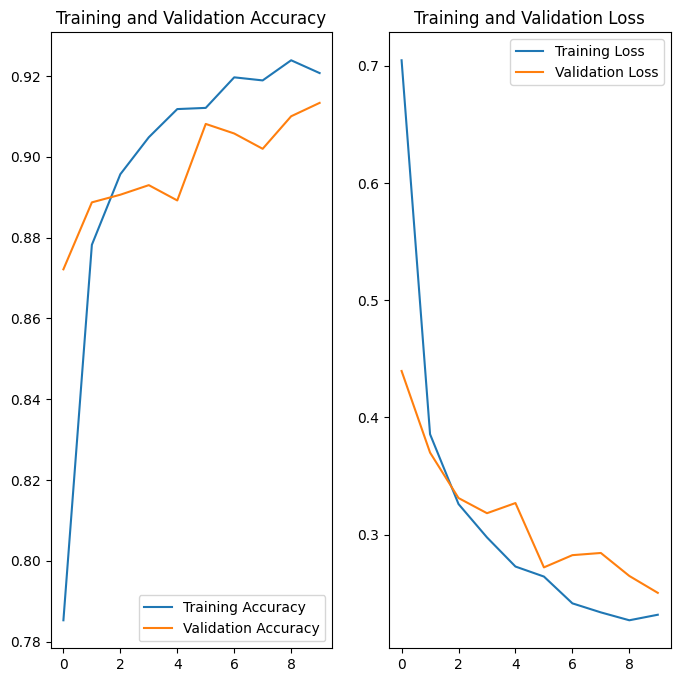

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Septoria leaf spot of Tomato
1/1 [==============================] - 2s 2s/step
predicted label: Septoria leaf spot of Tomato


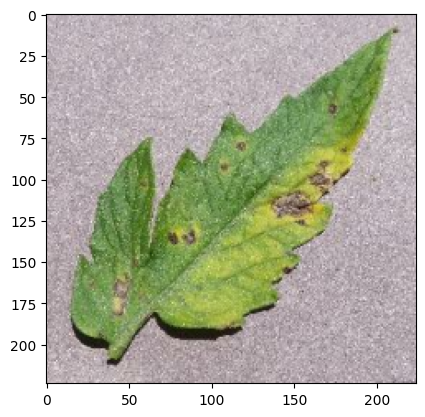

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 112ms/step


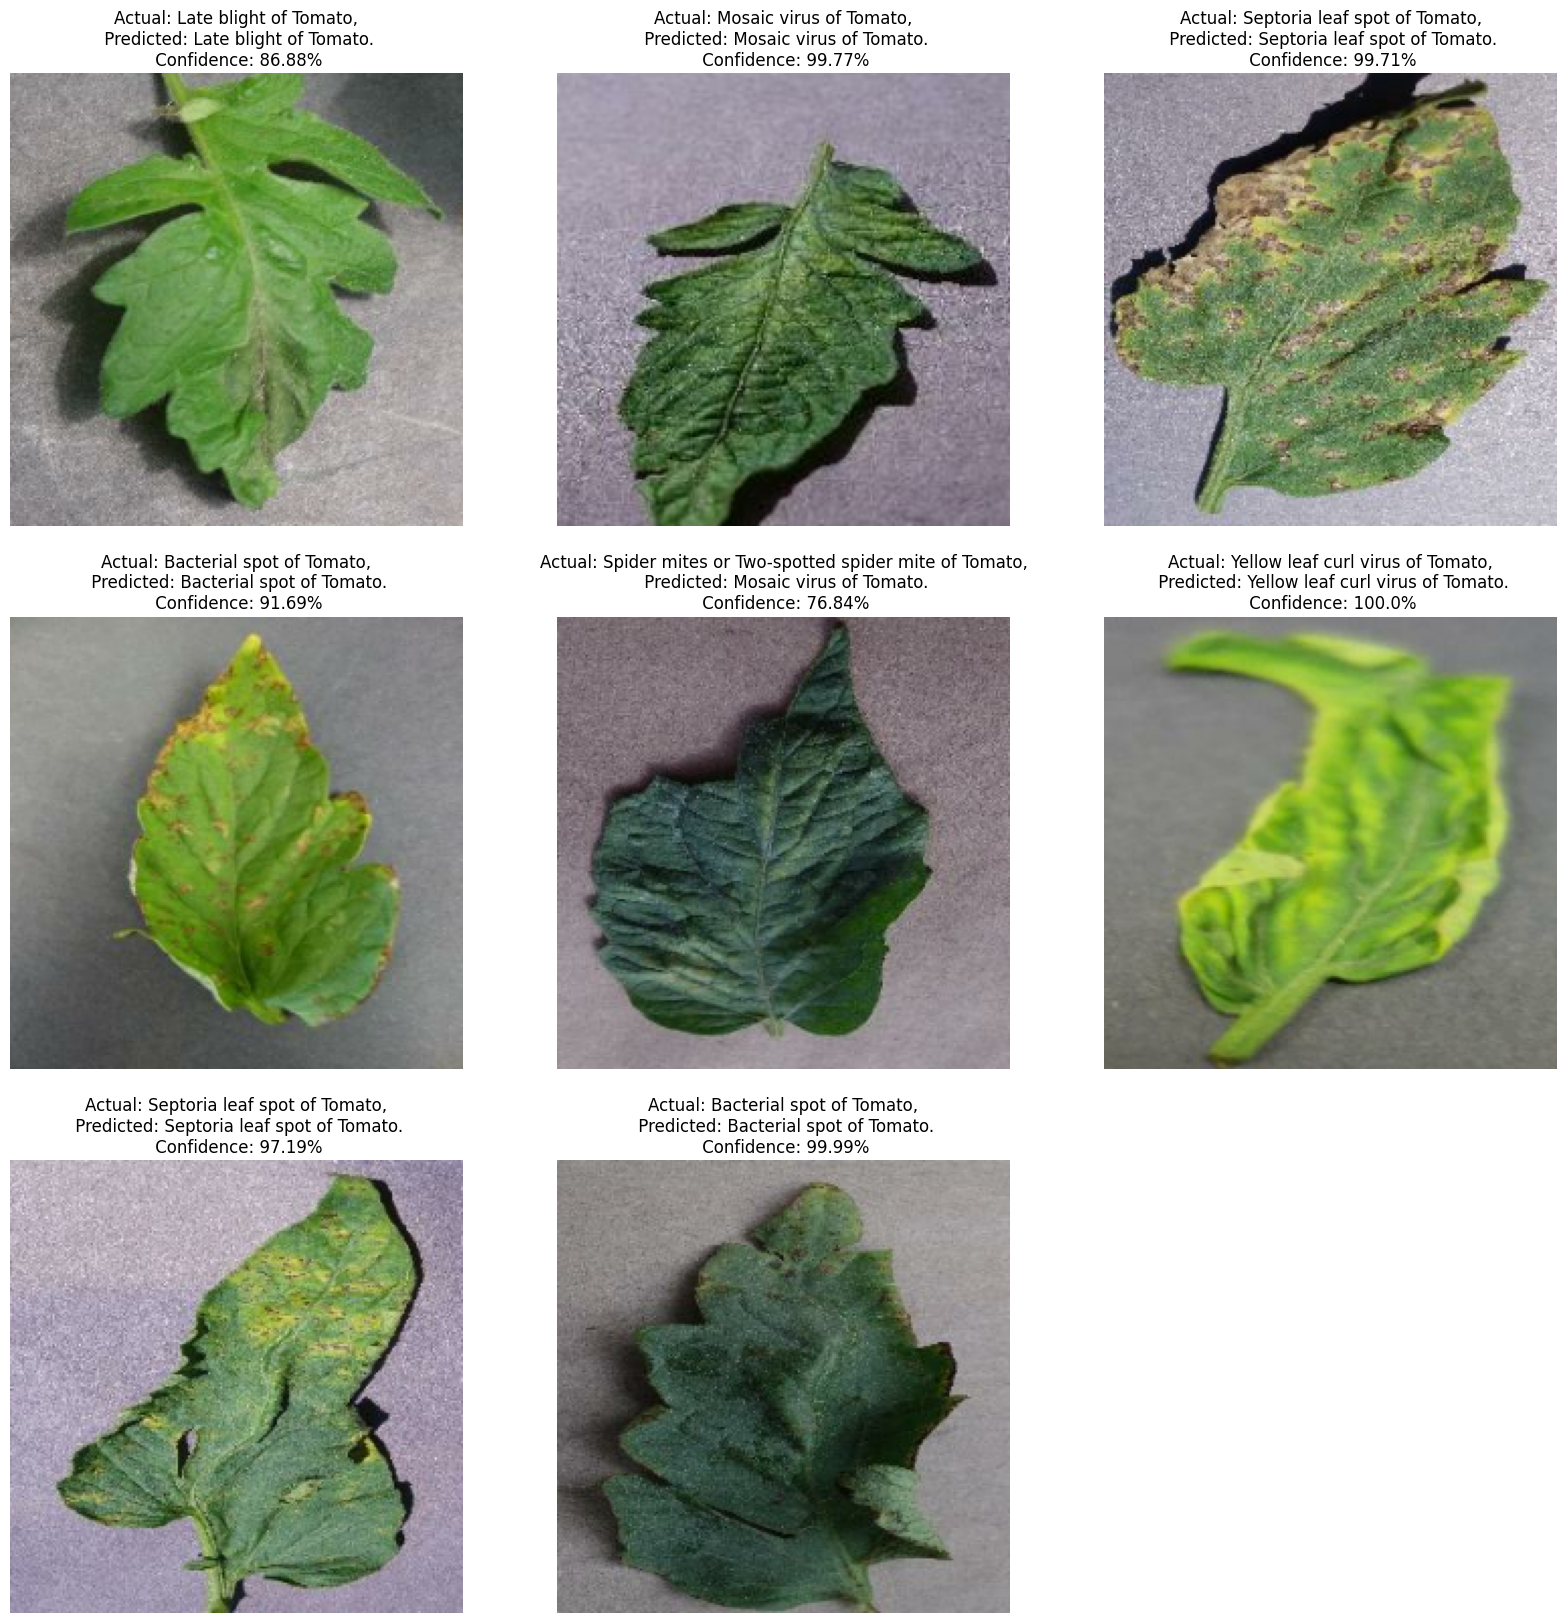

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
model_version = 1
model.save(f"drive/MyDrive/Colab Notebooks/Crop_Disease_Detection/{model_version}")